In [29]:
import math, os
import numpy as np
import pickle
from scipy import constants
from astropy.io import fits
from POSEIDON.constants import R_Sun, R_J, M_J
import numpy as np
from spectres import spectres
from datetime import datetime
from matplotlib.pyplot import *
import time
from array import *
from astropy.io import fits
import glob
from matplotlib import rcParams
import colormaps as cmaps
import matplotlib.pyplot as plt
import h5py

params = {
    "legend.fontsize": 25,
    "axes.labelsize": 40,
    "axes.titlesize": 40,
    "xtick.labelsize": 35,
    "ytick.labelsize": 35,
    "font.family": "serif",
    "font.size": 35,
    "mathtext.fontset": "cm",
    "mathtext.rm": "dejavuserif",
    "figure.facecolor": "white",
}

rcParams.update(params)

# TODO:
### 1. Migrate plotting function into high res
### 2. Make tutorials

In [30]:
def get_coordinate_list(x_values, y_values):
    x, y = np.meshgrid(x_values, y_values)
    coordinates = np.dstack([x, y]).reshape(-1, 2)
    return [tuple(coord) for coord in coordinates]

In [31]:
from POSEIDON.utility import read_high_res_data


def cross_correlation_plot(
    data_path, output_path, species, true_Kp, ture_Vsys, plot_label=False
):
    if isinstance(species, str):
        species = [species]
    data = h5py.File(data_path, "r")
    for s in species:
        loglikelihoods = []
        CCFs = []
        CCF_per_phases = []
        for key in ["blue", "redl", "redu"]:
            # Kp_arr, Vsys_arr, RV_range, loglikelihood, CCF, CCF_per_phase = pickle.load(
            #     open(output_path + "H2O_cross_correlation_results.pic", "rb")
            # )

            Kp_arr, Vsys_arr, loglikelihood, CCF, CCF_per_phase = (
                data[key][s]["Kp_arr"][:],
                data[key][s]["Vsys_arr"][:],
                # data[key][s]["RV_range"][:],
                data[key][s]["loglikelihood_map"][:],
                data[key][s]["CCF_map"][:],
                data[key][s]["CCF_per_phase"][:],
            )
            loglikelihoods.append(loglikelihood)
            CCFs.append(CCF)
            CCF_per_phases.append(CCF_per_phase)
        loglikelihoods = np.array(loglikelihoods)
        CCFs = np.array(CCFs)
        CCF_per_phases = np.array(CCF_per_phases)
        loglikelihood = np.sum(loglikelihoods, axis=0)
        CCF = np.sum(CCFs, axis=0)
        CCF_per_phase = np.sum(CCF_per_phases, axis=0)

        K_p = true_Kp
        V_sys = ture_Vsys  # True value

        stdev_range_x = np.where((Kp_arr < K_p - 20) | (Kp_arr > K_p + 20))[0]
        stdev_range_y = np.where((Vsys_arr < V_sys - 20) | (Vsys_arr > V_sys + 20))[0]
        stdev_range = get_coordinate_list(stdev_range_x, stdev_range_y)

        CCF = CCF - np.mean(CCF)
        stdev = np.std(CCF[stdev_range])
        maxx = (CCF / stdev).max()
        loc = np.where(CCF / stdev == maxx)
        fig, ax = subplots(figsize=(17, 17), constrained_layout=True)
        im = ax.imshow(
            CCF / stdev,
            extent=[Vsys_arr.min(), Vsys_arr.max(), Kp_arr.min(), Kp_arr.max()],
            aspect=len(Vsys_arr) / len(Kp_arr),
            interpolation="bilinear",
            cmap=cmaps.cividis,
            origin="lower",
        )
        if plot_label:
            ax.text(
                0.1,
                0.15,
                s,
                ha="left",
                va="top",
                transform=ax.transAxes,
                color="white",
                fontsize=60,
            )

        cbar = colorbar(im, shrink=0.8)
        axvline(x=V_sys, color="white", ls="--", lw=4)
        axhline(y=K_p, color="white", ls="--", lw=4)
        plot(Vsys_arr[loc[1]], Kp_arr[loc[0]], "xk", ms=20, mew=4)
        ax.set_xlabel("$\Delta$V$_{sys}$ (km/s)")
        ax.set_ylabel(r"K$_{p}$ (km/s)")
        ax.set_title(r"$\Delta$ CCF ($\sigma$)")
        savefig(output_path + s + "_CCF_SNR.png", bbox_inches="tight", pad_inches=0)
        show()
        close()

        loglikelihood = loglikelihood - np.mean(loglikelihood)
        stdev = np.std(loglikelihood[stdev_range])
        maxx = (loglikelihood / stdev).max()
        # loc = np.where(loglikelihood / stdev == maxx)
        # fig, ax = subplots(figsize=(17, 17), constrained_layout=True)
        # im = ax.imshow(
        #     loglikelihood / stdev,
        #     extent=[Vsys_arr.min(), Vsys_arr.max(), Kp_arr.min(), Kp_arr.max()],
        #     aspect=len(Vsys_arr) / len(Kp_arr),
        #     interpolation="bilinear",
        #     cmap=cmaps.cividis,
        #     origin="lower",
        # )

        # ax.text(
        #     0.1,
        #     0.15,
        #     s,
        #     ha="left",
        #     va="top",
        #     transform=ax.transAxes,
        #     color="white",
        #     fontsize=60,
        # )

        # cbar = colorbar(im, shrink=0.8)
        # axvline(x=V_sys, color="white", ls="--", lw=2)
        # axhline(y=K_p, color="white", ls="--", lw=2)
        # plot(Vsys_arr[loc[1]], Kp_arr[loc[0]], "xk", ms=20, mew=4)
        # ax.set_xlabel("$\Delta$V$_{sys}$ (km/s)")
        # ax.set_ylabel(r"K$_{p}$ (km/s)")
        # ax.set_title(r"$\Delta$ log($L$) ($\sigma$)")
        # savefig(output_path + s + "_CCF_SNR.png")
        # show()
        # close()

        # slice at Kp
        fig, ax = subplots(figsize=(17, 5), constrained_layout=True)
        index = np.argmin(np.abs(Kp_arr - Kp_arr[loc[0]]))

        slicee = CCF[index]
        ax.plot(Vsys_arr, slicee)
        ax.axis(
            [
                np.min(Vsys_arr),
                np.max(Vsys_arr),
                1.1 * slicee.min(),
                1.1 * slicee.max(),
            ]
        )
        ax.set_xlabel(r"$\Delta$V$_{sys}$(km/s)")
        ax.set_ylabel(r"$\Delta$ CCF")
        ax.set_title("Slice at K$_{p}$ = " + str(Kp_arr[loc[0]][0]) + " km/s")
        ax.axvline(x=V_sys, ls="--", color="black", lw=4)
        ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
        savefig(output_path + s + "_CCF_slice.png")
        show()
        close()
    data.close()

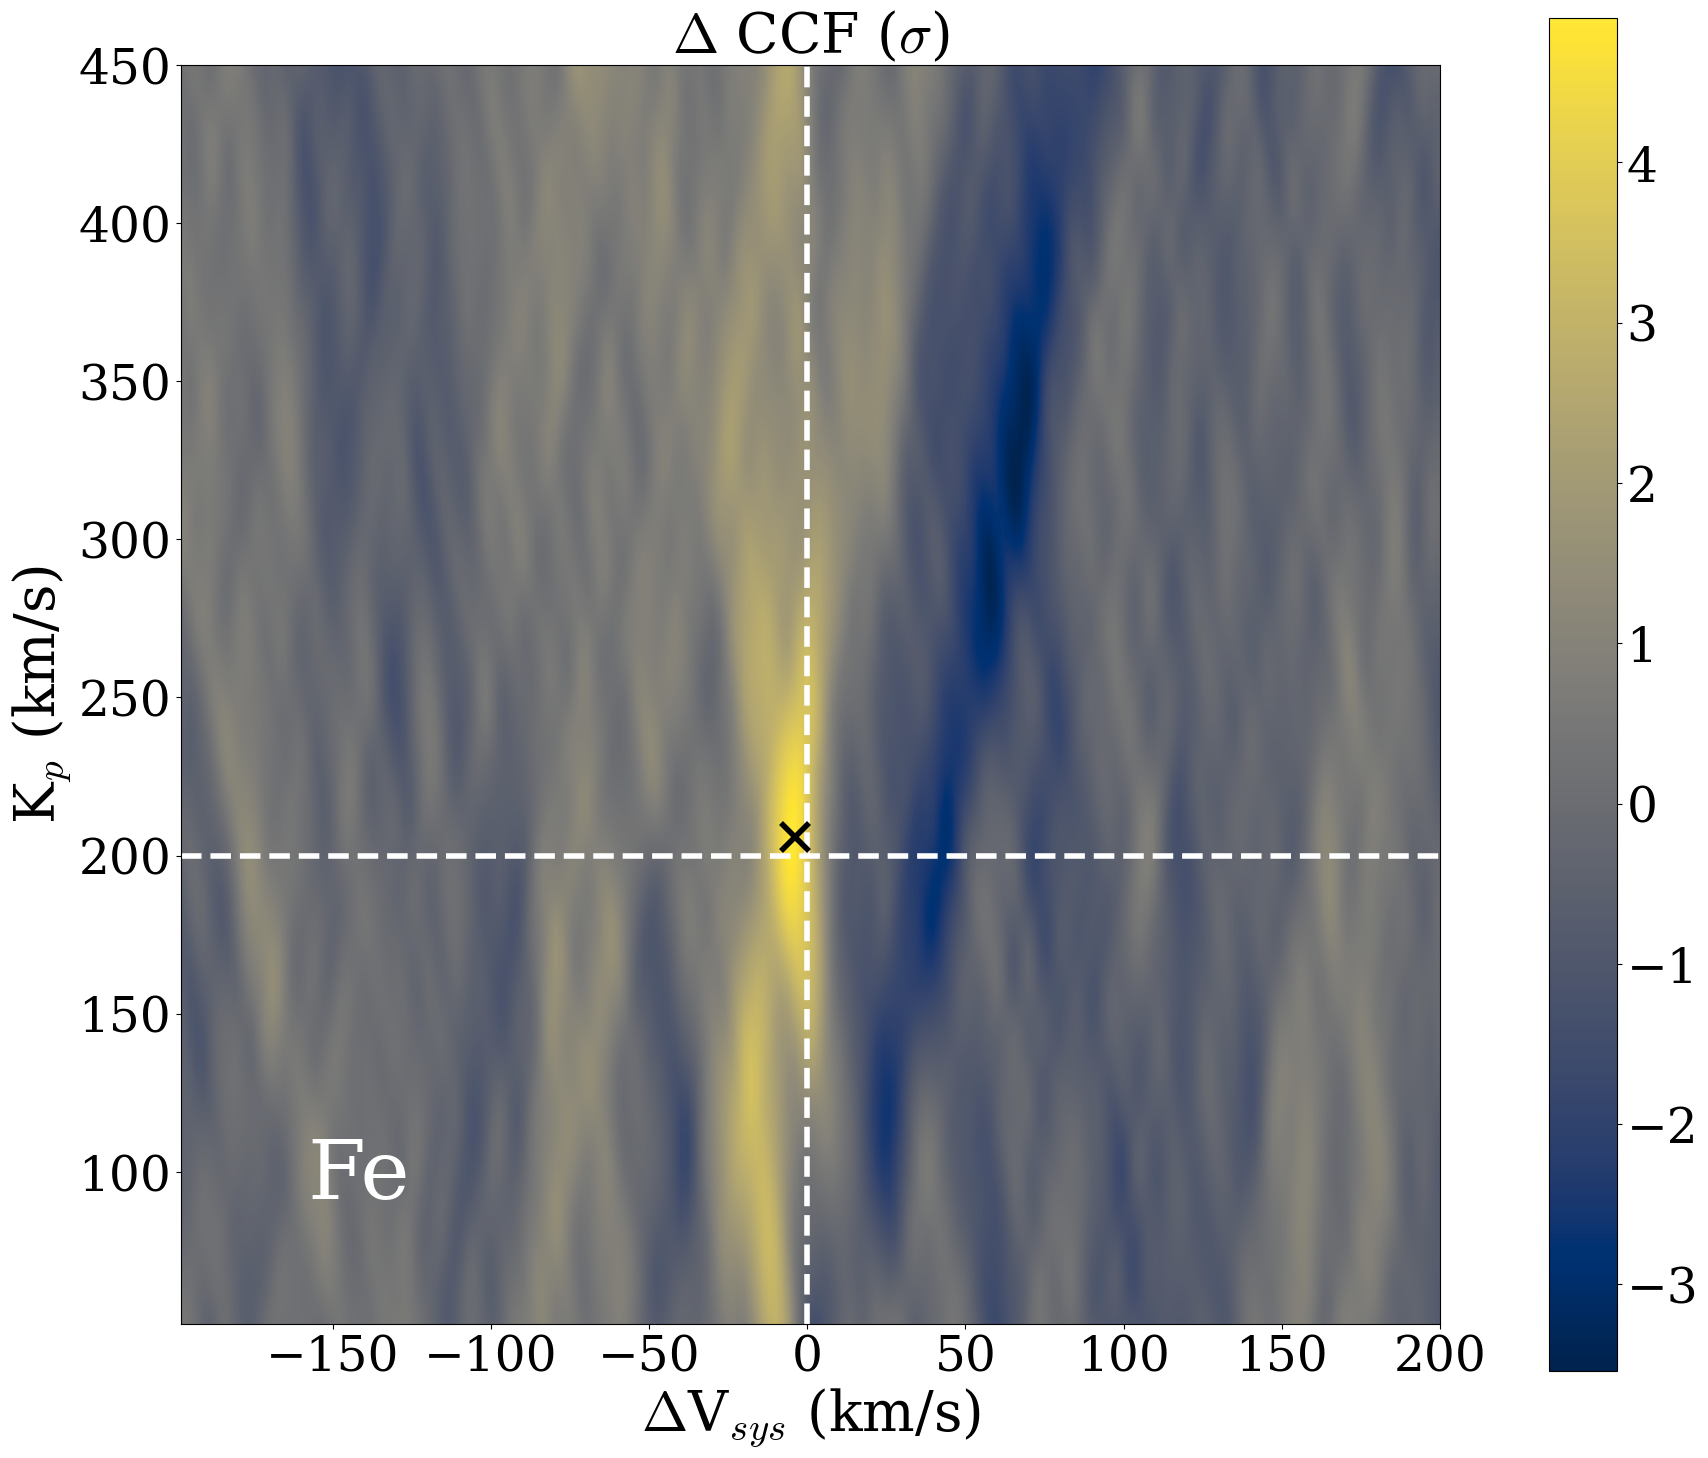

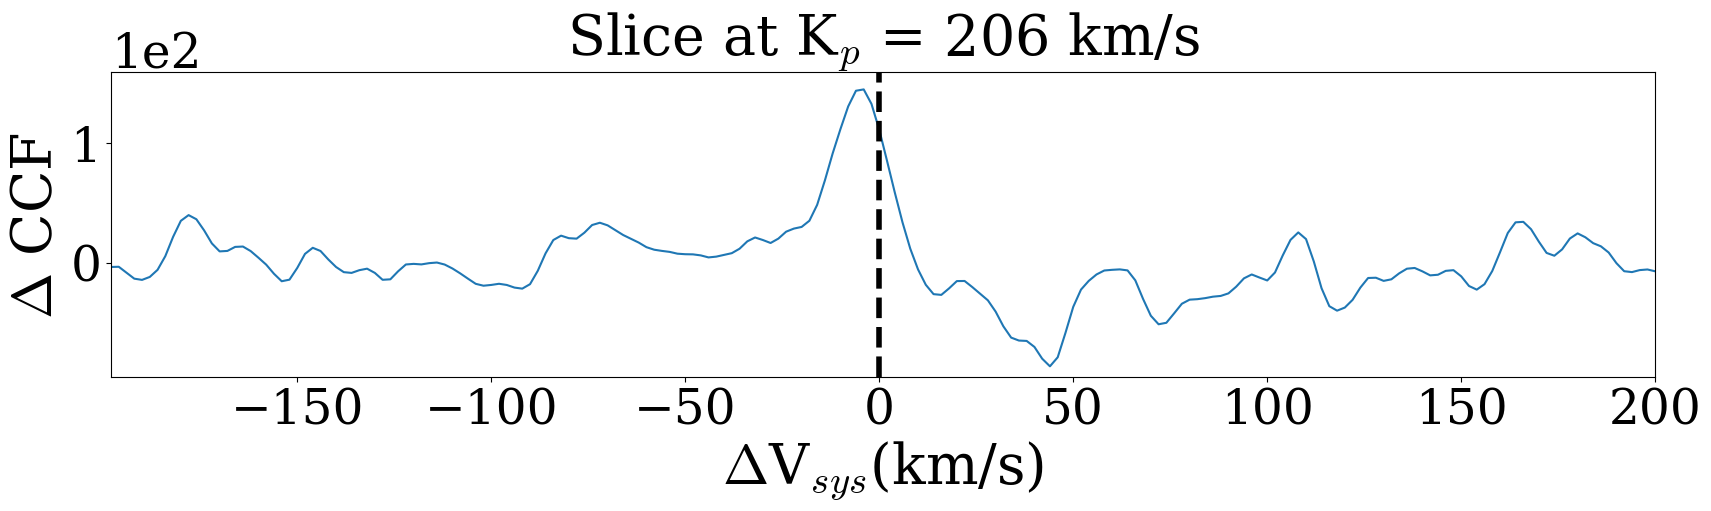

In [41]:
# output_path = "./CC_output/WASP-77Ab/"
# data_path = "./data/WASP-77Ab/"
# output_path = "./CC_output/WASP-121b-injection-a10/"
# data_path = "./data/WASP-121b-injection-a10/"
# output_path = "./CC_output/WASP-121b-injection/"
# data_path = "./data/WASP-121b-injection/"
output_path = "./CC_output/WASP-121b/"
data_path = "./data/WASP-121b/"
# output_path = "./CC_output/WASP-76b/"
# data_path = "./data/WASP-76b/"

cross_correlation_plot("./data/WASP-121.h5", output_path, "Fe", 200, 0, plot_label=True)
# cross_correlation_plot(data_path, output_path, "H2O, CO", 192.6, 0, plot_label=True)

In [5]:
# # for 121 injection
# for i in range(len(CCF_per_phase)):
#     CCF_per_phase[i] = CCF_per_phase[i] - np.mean(CCF_per_phase[i])
#     stdev = np.std(CCF_per_phase[i])
#     CCF_per_phase[i] = CCF_per_phase[i] / stdev
# maxx = (CCF_per_phase).max()
# print(maxx)
# loc = np.where(CCF_per_phase / stdev == maxx)
# fig, ax = subplots()
# cax = ax.imshow(
#     CCF_per_phase,
#     extent=[RV_range.min(), RV_range.max(), phi.min(), phi.max()],
#     aspect="auto",
#     # interpolation="bilinear",
#     # cmap="cividis",
#     cmap=cmaps.cividis,
#     origin="lower",
# )


# cbar = colorbar(cax)
# axvline(x=V_sys, color="white", ls="--", lw=2)
# axhline(y=0, color="white", ls="--", lw=2)
# plt.plot(
#     np.arange(-100, 50),
#     (np.arange(-100, 50) + 20) / (-200) / (2 * np.pi),
#     "--",
#     color="red",
#     alpha=0.5,
# )
# # plot(Vsys_arr[loc[1]], phi[loc[0]], "xk", ms=7)
# # axis([Vsys_arr.min(), Vsys_arr.max(), phi.min(), phi.max()])
# xlabel("Planet Velocity [km/s]")
# ylabel("Phase")
# title("$\Delta CCF (\sigma)$")
# show()
# close()